In [1]:
import numpy as np
import pandas as pd
# pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm import tqdm
tqdm.pandas()
import time
import copy
# import joblib
from collections import defaultdict
import gc
from IPython import display as ipd

# visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Sklearn
# from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

# PyTorch 
import torch
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision.transforms.functional as TF

#torchio
import torchio as tio

/home/dlim/python-virtual-envs/image-seg/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# class indices

LARGE_BOWEL = 0
SMALL_BOWEL = 1
STOMACH = 2
MASK_INDICES = {'large_bowel': LARGE_BOWEL, 'small_bowel':SMALL_BOWEL, 'stomach':STOMACH}

In [3]:
class CFG:
    seed          = 101
    debug         = False # set debug=False for Full Training
    train_bs      = 16
    valid_bs      = 16
    image_size    = [128, 128, 64] # Depth, Width, Height
    epochs        = 15
    lr            = 2e-3
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    hausdoff_distance_measure_size = (32, 32, 16)

In [4]:
torch.cuda.is_available()

True

In [5]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

> SEEDING DONE


In [6]:
def load_scans(scan_path):
    image_files = [f for f in os.listdir(scan_path) if os.path.isfile(os.path.join(scan_path, f))]
    image_files.sort(key=lambda x: int(x.split('_')[1]))
    
    scan_slices = []
    for img_file in image_files:
        img_file_path = os.path.join(scan_path, img_file)
        scan_slice = cv2.imread(img_file_path, cv2.IMREAD_UNCHANGED)
        scan_slice = scan_slice.astype('float32')
        scan_slices.append(scan_slice)
    
    img = np.stack(scan_slices)
    max_val = np.max(img)
    if max_val:
        img /= max_val

    return img

def load_mask(path):
    mask = np.load(path).transpose([3,0,1,2])
    mask = mask.astype('float32')
    return mask

# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Dataset

In [7]:
set_dimension_order_to_c_z_x_y = tio.Lambda(lambda x: torch.permute(x,(0,3,1,2)), types_to_apply=[tio.INTENSITY, tio.LABEL])

data_transforms = {
    "train": tio.Compose(
        [tio.RescaleIntensity(out_min_max=(0, 1)), 
         tio.Resize(target_shape=CFG.image_size, image_interpolation='linear', label_interpolation='nearest'), 
         tio.RandomFlip(axes=(0,1), p=0.2), 
         tio.RandomAffine(scales=(0.9, 1.2), degrees=15, p=0.2), 
         tio.OneOf([tio.RandomElasticDeformation(), tio.RandomMotion()], p=0.3), 
         tio.OneOf([tio.RandomGhosting(), tio.RandomSpike(), tio.RandomBlur()], p=0.3),
         # 
         
         set_dimension_order_to_c_z_x_y
        ]
    ),
    "valid": tio.Compose(
        [tio.RescaleIntensity(out_min_max=(0, 1)), 
         tio.Resize(target_shape=CFG.image_size, image_interpolation='linear', label_interpolation='nearest'),
         set_dimension_order_to_c_z_x_y]
    )
}

In [8]:
# Functions for creating Torchio Subject instances
def scan_reader(scan_path):
    image_files = [f for f in os.listdir(scan_path) if os.path.isfile(os.path.join(scan_path, f))]
    image_files.sort(key=lambda x: int(x.split('_')[1]))
    
    scan_slices = []
    for img_file in image_files:
        img_file_path = os.path.join(scan_path, img_file)
        scan_slice = cv2.imread(img_file_path, cv2.IMREAD_UNCHANGED)
        scan_slice = np.expand_dims(scan_slice, axis=0)
        scan_slice = scan_slice.astype('float32')
        scan_slices.append(scan_slice)
    
    img = np.stack(scan_slices, axis=-1)

    return img, None

def mask_reader(path):
    mask = np.load(path).transpose([3,0,1,2])
    mask = mask.astype('float32')
    return mask, None

def get_subject(case_day, scan_path, mask_path=None):
    if not mask_path:
        return tio.Subject(case_day=case_day, scan=tio.ScalarImage(path=scan_path, reader=scan_reader))

    return tio.Subject(
        case_day=case_day,
        scan=tio.ScalarImage(path=scan_path, reader=scan_reader),
        label=tio.LabelMap(path=mask_path, reader=mask_reader),
    )

In [9]:
# function for assigning fold to Data frame rows

def assign_fold_to_df(df, num_folds=5):
    num_rows = len(df)
    folds = np.zeros(num_rows, dtype='uint8')
    fold_vals = [i for i in range(num_folds)]
    indices = [i for i in range(num_rows)]
    random.shuffle(indices)
    random.shuffle(fold_vals)
    for i in indices:
        folds[i] = fold_vals[i % num_folds]

     # not shuffling fold_vals will cause some fold indices to always get less number of items than other fold indices.
    # EX: number of items is 2, and num_folds = 3. Assigning fold index with order [0,1,2] will make only fold-0 and fold-1 get an item, while fold-2 has 0 item.
 
    df['fold'] = folds

In [10]:
def prepare_loaders(df, fold, debug=False):
    train_df = df.query("fold!=@fold").reset_index(drop=True)
    valid_df = df.query("fold==@fold").reset_index(drop=True)
    
    train_dataset = tio.SubjectsDataset(
        [get_subject(row['case_day'], row['image_path'], row['mask_path']) for _, row in train_df.iterrows()], 
        transform=data_transforms['train']
    )
    valid_dataset = tio.SubjectsDataset(
        [get_subject(row['case_day'], row['image_path'], row['mask_path']) for _, row in valid_df.iterrows()], 
        transform=data_transforms['train']
    )

    train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs if not debug else 4, 
                              num_workers=4, shuffle=True, pin_memory=False, drop_last=False)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs if not debug else 4, 
                              num_workers=4, shuffle=False, pin_memory=False)
    
    return train_loader, valid_loader

In [11]:
# Load data frame

df_train = pd.read_csv('./input/uw-madison-gi-tract-image-segmentation/train.csv')
train_path = './input/uw-madison-gi-tract-image-segmentation/train'
df_train['case_day'] = df_train['id'].map(lambda x: x.split('_slice')[0])
df_train.drop(columns=['class', 'segmentation', 'id'], inplace=True)
df_train.drop_duplicates(inplace=True)
df_train['image_path'] = df_train['case_day'].map(lambda x: f'{train_path}/' + x.split('_')[0] + f'/{x}/scans')
df_train['mask_path'] =  df_train['case_day'].map(lambda x: f'{train_path}/' + x.split('_')[0] + f'/{x}/masks3D/{x}.npy')
assign_fold_to_df(df_train)
df_train.head(4)

,case_day,image_path,mask_path,fold
0,case123_day20,./input/uw-madison-gi-tract-image-segmentation...,./input/uw-madison-gi-tract-image-segmentation...,1
432,case123_day22,./input/uw-madison-gi-tract-image-segmentation...,./input/uw-madison-gi-tract-image-segmentation...,2
864,case123_day0,./input/uw-madison-gi-tract-image-segmentation...,./input/uw-madison-gi-tract-image-segmentation...,0
1296,case77_day20,./input/uw-madison-gi-tract-image-segmentation...,./input/uw-madison-gi-tract-image-segmentation...,3


In [11]:
gc.collect()

0

In [13]:
train_loader, valid_loader = prepare_loaders(df_train, fold=0, debug=True)

In [14]:
inputs = None
target = None
for subjects_batch in train_loader:
    inputs = subjects_batch['scan'][tio.DATA]
    target = subjects_batch['label'][tio.DATA]
    case_days = subjects_batch['case_day']
    break

In [15]:
inputs.shape

torch.Size([4, 1, 224, 224, 144])

In [16]:
target.shape

torch.Size([4, 3, 224, 224, 144])

In [17]:
case_days

['case47_day27', 'case119_day25', 'case35_day12', 'case18_day0']

In [15]:
mem_info = torch.cuda.mem_get_info(0)

In [16]:
mem_info

(10159652864, 11810701312)

### Compare with Transformed Data

Create Dataset and compare with the transformed image.\
You may want to temporaruily remove any spatial transformation that moves the original data along z-axis, \
because bellow code compares image with fixed slice number(z-axis value).

Skip bellow section, if you are done dataset debugging

In [ ]:
import glob

In [12]:
subject_dataset = tio.SubjectsDataset(
        [get_subject(row['case_day'], row['image_path'], row['mask_path']) for _, row in df_train.iterrows()], 
        transform=data_transforms['train']
    )

In [ ]:
# Select a subject
# By selecting an item with indexing, data transformation is perofrmed in bellow code.
# It will be performed again if you execute bellow code again even with the same index value.
subject = subject_dataset[3]

In [58]:
slice_num = 113 # z-axis value
case_day = subject['case_day']
case_day

(1, 266, 266, 144)


'case77_day20'

In [76]:
slice_num = 78

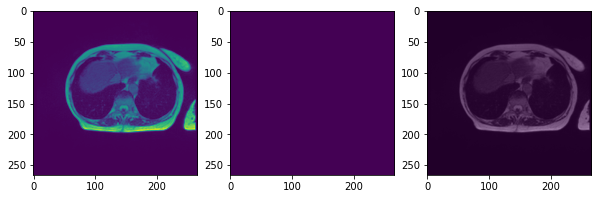

array([0., 0., 0.], dtype=float32)

In [77]:
# Show the original image

df_row = df_train.loc[df_train['case_day'] == case_day].iloc[0]
image_path = glob.glob(df_row['image_path'] + f'/slice_{str(slice_num).zfill(4)}_*.png')[0]
image = plt.imread(image_path)
mask = load_mask(df_row['mask_path'])[:, :, :, slice_num-1]
mask[1] *= 2
mask[2] *= 3
mask_sum = mask.sum(axis=0)
fig, ax = plt.subplots(1,3,figsize=(10,6))
ax[0].imshow(image)
ax[1].imshow(mask_sum)
ax[2].imshow(image,'gray')
ax[2].imshow(mask_sum, alpha=0.5)
plt.show()
mask.sum(axis=(1,2))

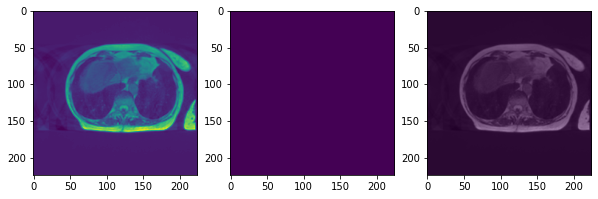

tensor([0., 0., 0.])

In [78]:
# Show trnsformed image
resized_slice_num = slice_num * CFG.image_size[2] // len(glob.glob(df_row['image_path'] + f'/slice_*.png')) 
image = subject['scan'][tio.DATA][0][:,:, resized_slice_num -1]
mask = subject['label'][tio.DATA][:,:,:, resized_slice_num - 1]
mask[1] *= 2
mask[2] *= 3
mask_sum = mask.sum(axis=0)
fig, ax = plt.subplots(1,3,figsize=(10,6))
ax[0].imshow(image)
ax[1].imshow(mask_sum)
ax[2].imshow(image,'gray')
ax[2].imshow(mask_sum, alpha=0.5)
plt.show()
mask.sum(axis=(1,2))

## Build Model

In [11]:
def double_conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv3d(in_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm3d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv3d(out_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm3d(out_channels),
        nn.ReLU(inplace=True),
    )

class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=3, features =[64, 128, 256, 512]):
        super(UNet3D, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

        #down part of UNet
        for feature in features:
            self.downs.append(double_conv_block(in_channels, feature))
            in_channels = feature

        #upsample part of UNet
        for feature in reversed(features):
            self.ups.append(
              nn.ConvTranspose3d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(double_conv_block(feature*2, feature))

            self.bottleneck = double_conv_block(features[-1], features[-1]*2)
            self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)


        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            # if x.shape != skip_connection.shape:
            #     x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [12]:
x = torch.randn((2,1, 128, 128, 64))
print(x.shape)
model = UNet3D()
# model.to(CFG.device)
# x = x.to(CFG.device, dtype=torch.float)
preds = model(x)

print(preds.shape)

torch.Size([2, 1, 128, 128, 64])
torch.Size([2, 3, 128, 128, 64])


In [ ]:
class DiceLoss(torch.nn.Module):
    def init(self):
        super(DiceLoss, self).init()
    def forward(self, pred, target):
        smooth = 1.
        iflat = pred.contiguous().view(-1)
        tflat = target.contiguous().view(-1)
        intersection = (iflat * tflat).sum()
        A_sum = torch.sum(iflat * iflat)
        B_sum = torch.sum(tflat * tflat)
        return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

        
class WeightedHausdorffLossRough(torch.nn.Module):
    def init(self, resized_shape):
        indices = np.indices(CFG.hausdoff_distance_measure_size).astype('float16') # using fixed shape, because otherwise memory is not enough
        indices += 0.5
        indices = indices.reshape(3, -1)
        indices_tr = np.transpose(indices)
        distances = np.sqrt(np.matmul(indices_tr, indices))
        max_distance = np.sqrt(np.sum(np.power(CFG.hausdoff_distance_measure_size, 2)))
        self.distances = torch.tensor(distances)
        self.max_distance = torch.tensor(max_distance)
        
        super(HausdorffLoss, self).init()
    def forward(self, pred, target):
        pred = torch.flatten(TF.resize(pred, size=CFG.hausdoff_distance_measure_size), start_dim=2)
        pred_unsqueezed = pred.unsqueeze(-2)
        weighted_distnaces = distance * pred_unsqueezed
        alpha = 1.0
        gen_mean_dist = torch.pow(
            torch.mean(
                torch.pow(
                    (weighted_distances + (1.0 - pred_unsqueezed) * self.max_distance), 
                    alpha
                ), 
                dim=3
            ), 
            1.0/alpha
        )
        
        ret = torch.sum(general_mean_dist * target, dim=2) // (torch.sum(target, dim=2) + 0.000006)
        
        target = torch.flatten(TF.resize(target, size=CFG.hausdoff_distance_measure_size), start_dim=2).unsqueeze(-1)
        y_masked_distances = distances + ((1.0 - target) * self.max_distance)
        min_dist, _ = torch.min(y_masked_distances, dim=2)
        ret += torch.sum(min_dist * pred, dim=-1)
        
        return torch.sum(ret, dim=-1) # sum the hausdorff distance of all labels

class WeightedHausdorffLoss(torch.nn.Module):
    def init(self, num_classes, resized_shape, alpha=-1.0, device=torch.device('cpu')):
        self.alpha = alhpa
        self.width, self.height, self.depth = resized_shape
        self.num_classes = num_classes
        self.resized_size = torch.tensor(resized_shape,
                                         dtype=torch.get_default_dtype(),
                                         device=device)
        self.max_distance = np.sqrt(resized_shape[0]**2 + resized_shape[1]**2 + resized_shape[2]**2) 
        self.n_pixels = np.prod(resized_shape)
        
        self.all_pixel_locations = torch.from_numpy(
            np.indices(resized_shape, dtype=np.int32).reshape(3,-1).transpose()
        ).to(device=device, dtype=torch.get_default_dtype())
        super(WeightedHausdorffLoss, self).init()
        
    def forward(self, prob_map, gt, orig_sizes):
        """
        Compute the Weighted Hausdorff Distance function
        between the estimated probability map and ground truth points.
        The output is the WHD averaged through all the batch.
        :param prob_map: (B x C x W x H x D) Tensor of the probability map of the estimation.
                         B is batch size, C is number of classes, H is height, W is width and D is depth.
                         Values must be between 0 and 1.
        :param gt: List of List of Tensors of the Ground Truth points.
                   The outer most list must be of size B as in prob_map.
                   The second outer most list must be of size C.
                   Each element in the second outer most list must be a 2D Tensor,
                   where each row is the (x, y, z), i.e, (col, row, depth) of a GT point.
        :param orig_sizes: Bx3 Tensor containing the size
                           of the original images.
                           B is batch size.
                           The size must be in (width, height, depth) format.
        :return: Single-scalar Tensor with the Weighted Hausdorff Distance.
                 If self.return_2_terms=True, then return a tuple containing
                 the two terms of the Weighted Hausdorff Distance.
        """

        _assert_no_grad(gt)

        assert prob_map.dim() == 5, 'The probability map shape must be (B x C x W x H x D)'
        assert prob_map.size()[1:4] == (self.num_classes, self.width, self.height, self.depth), \
        f'prob_map size is {prob_map.size()[2:3]}, it must have size {(self.num_classes, self.width, self.height, self.depth)}'

        batch_size = prob_map.shape[0]
        assert batch_size == len(gt)

        distances_by_class = [[] for _ in range(num_classes)]
        class_distance_sum = []
        for batch_index in range(batch_size):
            orig_size_b = orig_sizes[batch_index, :]
            norm_factor = (orig_size_b/self.resized_size)
            for class_index in range(self.num_classes):
                # One by one
                prob_map_b = prob_map[batch_index, class_index]
                gt_b = gt[batch_index][class_index]
                
                n_gt_pts = gt_b.size()[0]

                # Corner case: no GT points
                if gt_b.ndimension() == 1 and (gt_b < 0).all().item() == 0:
                    terms_1[class_index].append(torch.tensor([self.max_dist], dtype=torch.get_default_dtype()))
                    terms_2[class_index].append(torch.tensor([0], dtype=torch.get_default_dtype()))
                    continue

                # Pairwise distances between all possible locations and the GTed locations
                n_gt_pts = gt_b.size()[0]
                
                # normalized_x has shape (width * height * depth, 3)
                # normalized_y has shape (number of masked points, 3)
                normalized_x = norm_factor * self.all_img_locations
                normalized_y = norm_factor * gt_b

                # normalized_x.unsqueeze(1) has shape (width * height * depth, 1, 3)
                # normalized_y.unsqueeze(0) has shape (1, number of masked points, 3)
                # diff has shape (width * height * depth, number of true segmented points, 3)
                diffs = normalized_x.unsqueeze(1) - normalized_y.unsqueeze(0)
                
                # distances has shape (width * height * depth, number of true segmented points)
                distance_matrix = torch.sum(diffs ** 2, -1).sqrt()

                # Reshape probability map as a long column vector,
                # and prepare it for multiplication
                p = prob_map_b.view(prob_map_b.nelement())
                total_x_weight = p.sum()

                # Weighted Hausdorff Distance
                term_1 = (1 / (total_x_weight + 1e-6)) * torch.sum(p * torch.min(distance_matrix, 1)[0])
                
                p = p.view(-1, 1)
                weighted_d_matrix = (1 - p)*self.max_dist + p*d_matrix
                
                # get generalized mean
                generalized_mean = torch.mean((weighted_matrix + 1e-6)**p, 0)**(1./p)
                term_2 = torch.mean(generalized_mean)
                
                result = term_1 + term_2
                distances_by_class[class_index].append(result)

        if self.return_by_class
            return [torch.stack(class_result).mean() for class_result in weighted_distances]

        batch_results = []
        for batch_index in range(batch_size):
            class_total_dist = torch.stack([distances_by_class[class_index][batch_index] for class_index in range(self.num_classes)]).sum()
            batch_results.append(class_total_dist)

        return torch.stack(batch_results).mean()

In [15]:
pred = torch.tensor([[[0,0,0,0,], [0,0,0.9,0.5], [0.8,0,0,0],], [[0.7,0.8,1.0,1.0], [1.0,0,0,0.3], [0,0,0,0],]])
pred.shape

torch.Size([2, 3, 4])

In [24]:
orig_sizes = torch.tensor([[244, 244, 144], [256,256,122]])

In [25]:
resized_size = torch.tensor([128, 128, 64])

In [39]:
norm = (orig_sizes[1] / resized_size)

In [40]:
norm.shape

torch.Size([3])

In [41]:
indices = np.indices((4,5,3), dtype=np.int32) # using fixed shape, because otherwise memory is not enough
indices = indices.reshape(3, -1)
all_pixel_locations = torch.from_numpy(indices.transpose()
        )

In [43]:
all_pixel_locations.shape

torch.Size([60, 3])

In [53]:
norm.repeat(4, 1)

tensor([[2.0000, 2.0000, 1.9062],
        [2.0000, 2.0000, 1.9062],
        [2.0000, 2.0000, 1.9062],
        [2.0000, 2.0000, 1.9062]])

In [46]:
normalized_x = all_pixel_locations * norm

In [33]:
gt_b = torch.tensor([])

In [34]:
gt_b.ndimension()

1

In [57]:
gt_b = torch.tensor([[0,0,0], [3,2,1], [1,3,2],[2,2,2]])

In [38]:
(gt_b < 0).all().item()

False

In [58]:
normalized_y = gt_b * norm

In [59]:
normalized_x.shape, normalized_y.shape

(torch.Size([60, 3]), torch.Size([4, 3]))

In [60]:
unsqueezed_x = normalized_x.unsqueeze(1) 
unsqueezed_y = normalized_y.unsqueeze(0)
unsqueezed_x.shape, unsqueezed_y.shape

(torch.Size([60, 1, 3]), torch.Size([1, 4, 3]))

In [63]:
diff = unsqueezed_y - unsqueezed_x

In [64]:
diff.shape

torch.Size([60, 4, 3])

In [66]:
distances = torch.sum(diff ** 2, -1).sqrt()

In [67]:
distances.shape

torch.Size([60, 4])

In [68]:
pred = torch.tensor([i/60.0 for i in range(60)])

In [69]:
pred.shape

torch.Size([60])

In [72]:
distances

tensor([[ 0.0000,  7.4588,  7.3848,  6.8217],
        [ 1.9062,  7.2111,  6.6056,  5.9694],
        [ 3.8125,  7.4588,  6.3246,  5.6569],
        [ 2.0000,  6.6056,  5.8767,  5.8767],
        [ 2.7629,  6.3246,  4.8615,  4.8615],
        [ 4.3052,  6.6056,  4.4721,  4.4721],
        [ 4.0000,  6.2955,  4.7471,  5.5259],
        [ 4.4310,  6.0000,  3.4108,  4.4310],
        [ 5.5259,  6.2955,  2.8284,  4.0000],
        [ 6.0000,  6.6056,  4.3052,  5.8767],
        [ 6.2955,  6.3246,  2.7629,  4.8615],
        [ 7.1088,  6.6056,  2.0000,  4.4721],
        [ 8.0000,  7.4588,  4.7471,  6.8217],
        [ 8.2240,  7.2111,  3.4108,  5.9694],
        [ 8.8620,  7.4588,  2.8284,  5.6569],
        [ 2.0000,  5.9694,  7.1088,  5.8767],
        [ 2.7629,  5.6569,  6.2955,  4.8615],
        [ 4.3052,  5.9694,  6.0000,  4.4721],
        [ 2.8284,  4.8615,  5.5259,  4.7471],
        [ 3.4108,  4.4721,  4.4310,  3.4108],
        [ 4.7471,  4.8615,  4.0000,  2.8284],
        [ 4.4721,  4.4310,  4.3052

In [73]:
weighted = pred.view(-1, 1)* distances

In [74]:
weighted.shape

torch.Size([60, 4])

In [4]:
gc.collect()
indices = np.indices(CFG.hausdoff_distance_measure_size).astype('float16') # using fixed shape, because otherwise memory is not enough
indices += 0.5
indices = indices.reshape(3, -1)
indices_tr = np.transpose(indices)
distances = np.sqrt(np.matmul(indices_tr, indices))
max_distance = np.sqrt(np.sum(np.power(CFG.hausdoff_distance_measure_size, 2)))
# distances = torch.tensor(distances)
# max_distance = torch.tensor(max_distance)

In [14]:
indices.dtype

dtype('int16')

In [98]:
distances.shape

(16384, 16384)

In [99]:
max_distance

48.0

In [100]:
np.max(distances)

47.16

In [91]:
np.prod(CFG.hausdoff_distance_measure_size)

16384

In [4]:
a = torch.tensor([[1,2,3,4], [4,5,6,7], [7,8,9,10], [10, 11, 12, 13]])
a.shape

torch.Size([4, 4])

In [5]:
a

tensor([[ 1,  2,  3,  4],
        [ 4,  5,  6,  7],
        [ 7,  8,  9, 10],
        [10, 11, 12, 13]])

In [6]:
b = torch.tensor([[[0,0,0,0,], [0,0,1,1], [1,0,0,0],], [[1,1,1,1], [1,0,0,1], [0,0,0,0],]])
b.shape

torch.Size([2, 3, 4])

In [7]:
pred = torch.tensor([[[0,0,0,0,], [0,0,0.9,0.5], [0.8,0,0,0],], [[0.7,0.8,1.0,1.0], [1.0,0,0,0.3], [0,0,0,0],]])
pred.shape

torch.Size([2, 3, 4])

In [8]:
pred

tensor([[[0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.9000, 0.5000],
         [0.8000, 0.0000, 0.0000, 0.0000]],

        [[0.7000, 0.8000, 1.0000, 1.0000],
         [1.0000, 0.0000, 0.0000, 0.3000],
         [0.0000, 0.0000, 0.0000, 0.0000]]])

In [9]:
pred_unsqueezed = pred.unsqueeze(-2)

In [10]:
pred_unsqueezed.shape

torch.Size([2, 3, 1, 4])

In [11]:
weighted = pred_unsqueezed * a

In [12]:
weighted

tensor([[[[ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  2.7000,  2.0000],
          [ 0.0000,  0.0000,  5.4000,  3.5000],
          [ 0.0000,  0.0000,  8.1000,  5.0000],
          [ 0.0000,  0.0000, 10.8000,  6.5000]],

         [[ 0.8000,  0.0000,  0.0000,  0.0000],
          [ 3.2000,  0.0000,  0.0000,  0.0000],
          [ 5.6000,  0.0000,  0.0000,  0.0000],
          [ 8.0000,  0.0000,  0.0000,  0.0000]]],


        [[[ 0.7000,  1.6000,  3.0000,  4.0000],
          [ 2.8000,  4.0000,  6.0000,  7.0000],
          [ 4.9000,  6.4000,  9.0000, 10.0000],
          [ 7.0000,  8.8000, 12.0000, 13.0000]],

         [[ 1.0000,  0.0000,  0.0000,  1.2000],
          [ 4.0000,  0.0000,  0.0000,  2.1000],
          [ 7.0000,  0.0000,  0.0000,  3.0000],
          [10.0000,  0.0000,  0.0000,  3.9000]],

         [[ 0.0000,  0.0000,

In [13]:
weited_with_max = weighted + ((1 - pred_unsqueezed) * 1000)

In [14]:
weited_with_max.shape

torch.Size([2, 3, 4, 4])

In [15]:
weited_with_max

tensor([[[[1000.0000, 1000.0000, 1000.0000, 1000.0000],
          [1000.0000, 1000.0000, 1000.0000, 1000.0000],
          [1000.0000, 1000.0000, 1000.0000, 1000.0000],
          [1000.0000, 1000.0000, 1000.0000, 1000.0000]],

         [[1000.0000, 1000.0000,  102.7000,  502.0000],
          [1000.0000, 1000.0000,  105.4000,  503.5000],
          [1000.0000, 1000.0000,  108.1000,  505.0000],
          [1000.0000, 1000.0000,  110.8000,  506.5000]],

         [[ 200.8000, 1000.0000, 1000.0000, 1000.0000],
          [ 203.2000, 1000.0000, 1000.0000, 1000.0000],
          [ 205.6000, 1000.0000, 1000.0000, 1000.0000],
          [ 208.0000, 1000.0000, 1000.0000, 1000.0000]]],


        [[[ 300.7000,  201.6000,    3.0000,    4.0000],
          [ 302.8000,  204.0000,    6.0000,    7.0000],
          [ 304.9000,  206.4000,    9.0000,   10.0000],
          [ 307.0000,  208.8000,   12.0000,   13.0000]],

         [[   1.0000, 1000.0000, 1000.0000,  701.2000],
          [   4.0000, 1000.0000, 1000.

In [16]:
torch.mean(weited_with_max, dim=3)

tensor([[[1000.0000, 1000.0000, 1000.0000, 1000.0000],
         [ 651.1750,  652.2250,  653.2750,  654.3250],
         [ 800.2000,  800.8000,  801.4000,  802.0000]],

        [[ 127.3250,  129.9500,  132.5750,  135.2000],
         [ 675.5500,  676.5250,  677.5000,  678.4750],
         [1000.0000, 1000.0000, 1000.0000, 1000.0000]]])

In [17]:
1.0 / weited_with_max

tensor([[[[0.0010, 0.0010, 0.0010, 0.0010],
          [0.0010, 0.0010, 0.0010, 0.0010],
          [0.0010, 0.0010, 0.0010, 0.0010],
          [0.0010, 0.0010, 0.0010, 0.0010]],

         [[0.0010, 0.0010, 0.0097, 0.0020],
          [0.0010, 0.0010, 0.0095, 0.0020],
          [0.0010, 0.0010, 0.0093, 0.0020],
          [0.0010, 0.0010, 0.0090, 0.0020]],

         [[0.0050, 0.0010, 0.0010, 0.0010],
          [0.0049, 0.0010, 0.0010, 0.0010],
          [0.0049, 0.0010, 0.0010, 0.0010],
          [0.0048, 0.0010, 0.0010, 0.0010]]],


        [[[0.0033, 0.0050, 0.3333, 0.2500],
          [0.0033, 0.0049, 0.1667, 0.1429],
          [0.0033, 0.0048, 0.1111, 0.1000],
          [0.0033, 0.0048, 0.0833, 0.0769]],

         [[1.0000, 0.0010, 0.0010, 0.0014],
          [0.2500, 0.0010, 0.0010, 0.0014],
          [0.1429, 0.0010, 0.0010, 0.0014],
          [0.1000, 0.0010, 0.0010, 0.0014]],

         [[0.0010, 0.0010, 0.0010, 0.0010],
          [0.0010, 0.0010, 0.0010, 0.0010],
          [0.0010, 0

In [18]:
1.0 / torch.mean(1.0 / weited_with_max, dim=3)

tensor([[[999.9999, 999.9999, 999.9999, 999.9999],
         [291.3513, 296.8733, 302.3228, 307.7017],
         [501.2481, 504.9701, 508.6590, 512.3152]],

        [[  6.7611,  12.5894,  18.2452,  23.7667],
         [  3.9863,  15.7838,  27.3449,  38.6770],
         [999.9999, 999.9999, 999.9999, 999.9999]]])

In [19]:
general_mean = torch.pow(torch.mean(torch.pow(weited_with_max, -1), dim=3), -1)

In [20]:
b

tensor([[[0, 0, 0, 0],
         [0, 0, 1, 1],
         [1, 0, 0, 0]],

        [[1, 1, 1, 1],
         [1, 0, 0, 1],
         [0, 0, 0, 0]]])

In [21]:
general_mean * b

tensor([[[  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000, 302.3228, 307.7017],
         [501.2481,   0.0000,   0.0000,   0.0000]],

        [[  6.7611,  12.5894,  18.2452,  23.7667],
         [  3.9863,   0.0000,   0.0000,  38.6770],
         [  0.0000,   0.0000,   0.0000,   0.0000]]])

In [22]:
ret = torch.sum(general_mean * b, dim=2) / (torch.sum(b, dim=2) + 0.00006)

In [23]:
ret

tensor([[  0.0000, 305.0031, 501.2180],
        [ 15.3404,  21.3310,   0.0000]])

In [24]:
ret = torch.sum(ret)

In [25]:
ret

tensor(842.8925)

In [28]:
b = b.unsqueeze(-1)

In [29]:
b.shape

torch.Size([2, 3, 4, 1])

In [30]:
b

tensor([[[[0],
          [0],
          [0],
          [0]],

         [[0],
          [0],
          [1],
          [1]],

         [[1],
          [0],
          [0],
          [0]]],


        [[[1],
          [1],
          [1],
          [1]],

         [[1],
          [0],
          [0],
          [1]],

         [[0],
          [0],
          [0],
          [0]]]])

In [32]:
masked = a + ( (1.0 - b) * 100)

In [33]:
masked

tensor([[[[101., 102., 103., 104.],
          [104., 105., 106., 107.],
          [107., 108., 109., 110.],
          [110., 111., 112., 113.]],

         [[101., 102., 103., 104.],
          [104., 105., 106., 107.],
          [  7.,   8.,   9.,  10.],
          [ 10.,  11.,  12.,  13.]],

         [[  1.,   2.,   3.,   4.],
          [104., 105., 106., 107.],
          [107., 108., 109., 110.],
          [110., 111., 112., 113.]]],


        [[[  1.,   2.,   3.,   4.],
          [  4.,   5.,   6.,   7.],
          [  7.,   8.,   9.,  10.],
          [ 10.,  11.,  12.,  13.]],

         [[  1.,   2.,   3.,   4.],
          [104., 105., 106., 107.],
          [107., 108., 109., 110.],
          [ 10.,  11.,  12.,  13.]],

         [[101., 102., 103., 104.],
          [104., 105., 106., 107.],
          [107., 108., 109., 110.],
          [110., 111., 112., 113.]]]])

In [37]:
min_dist, _ = torch.min(masked, dim=2)

In [38]:
min_dist

tensor([[[101., 102., 103., 104.],
         [  7.,   8.,   9.,  10.],
         [  1.,   2.,   3.,   4.]],

        [[  1.,   2.,   3.,   4.],
         [  1.,   2.,   3.,   4.],
         [101., 102., 103., 104.]]])

In [39]:
min_dist.shape

torch.Size([2, 3, 4])

In [35]:
pred.shape

torch.Size([2, 3, 4])

In [36]:
pred

tensor([[[0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.9000, 0.5000],
         [0.8000, 0.0000, 0.0000, 0.0000]],

        [[0.7000, 0.8000, 1.0000, 1.0000],
         [1.0000, 0.0000, 0.0000, 0.3000],
         [0.0000, 0.0000, 0.0000, 0.0000]]])

In [40]:
torch.sum(min_dist * pred, dim=-1)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 8.1000, 5.0000],
         [0.8000, 0.0000, 0.0000, 0.0000]],

        [[0.7000, 1.6000, 3.0000, 4.0000],
         [1.0000, 0.0000, 0.0000, 1.2000],
         [0.0000, 0.0000, 0.0000, 0.0000]]])

In [41]:
torch.sum(min_dist * pred, dim=-1)

tensor([[ 0.0000, 13.1000,  0.8000],
        [ 9.3000,  2.2000,  0.0000]])

In [42]:
torch.sum(min_dist * pred)

tensor(25.4000)

In [37]:
c.shape

torch.Size([2, 3, 4, 4])

In [38]:
c

tensor([[[[100.0000, 100.0000, 100.0000, 100.0000],
          [100.0000, 100.0000, 100.0000, 100.0000],
          [100.0000, 100.0000, 100.0000, 100.0000],
          [100.0000, 100.0000, 100.0000, 100.0000]],

         [[100.0000, 100.0000, 102.7000, 102.0000],
          [100.0000, 100.0000, 105.4000, 103.5000],
          [  0.0000,   0.0000,   8.1000,   5.0000],
          [  0.0000,   0.0000,  10.8000,   6.5000]],

         [[  0.8000,   0.0000,   0.0000,   0.0000],
          [103.2000, 100.0000, 100.0000, 100.0000],
          [105.6000, 100.0000, 100.0000, 100.0000],
          [108.0000, 100.0000, 100.0000, 100.0000]]],


        [[[  0.7000,   1.6000,   3.0000,   4.0000],
          [  2.8000,   4.0000,   6.0000,   7.0000],
          [  4.9000,   6.4000,   9.0000,  10.0000],
          [  7.0000,   8.8000,  12.0000,  13.0000]],

         [[  1.0000,   0.0000,   0.0000,   1.2000],
          [104.0000, 100.0000, 100.0000, 102.1000],
          [107.0000, 100.0000, 100.0000, 103.0000],
  

In [39]:
min_dist, _ = torch.min(c, dim=2)

In [40]:
min_dist

tensor([[[100.0000, 100.0000, 100.0000, 100.0000],
         [  0.0000,   0.0000,   8.1000,   5.0000],
         [  0.8000,   0.0000,   0.0000,   0.0000]],

        [[  0.7000,   1.6000,   3.0000,   4.0000],
         [  1.0000,   0.0000,   0.0000,   1.2000],
         [100.0000, 100.0000, 100.0000, 100.0000]]])

In [114]:
min_dist.shape

torch.Size([2, 3, 4])

In [110]:
pred

tensor([[[0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.9000, 0.5000],
         [0.8000, 0.0000, 0.0000, 0.0000]],

        [[0.7000, 0.8000, 1.0000, 1.0000],
         [1.0000, 0.0000, 0.0000, 0.3000],
         [0.0000, 0.0000, 0.0000, 0.0000]]])

In [61]:
torch.sum(min_dist) / (torch.sum(pred) + 0.0006)

tensor(126.2749)

In [113]:
pred * min_dist

tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  2.7000,  2.0000],
         [ 3.2000,  0.0000,  0.0000,  0.0000]],

        [[28.7000, 33.6000, 43.0000, 44.0000],
         [ 4.0000,  0.0000,  0.0000,  2.1000],
         [ 0.0000,  0.0000,  0.0000,  0.0000]]])

In [52]:
b[0] * a  

RuntimeError: The size of tensor a (2) must match the size of tensor b (3) at non-singleton dimension 1

In [19]:
item = np.zeros((10,13,7), )

AttributeError: module 'numpy' has no attribute 'zeroes'

In [22]:
index_val = 0
something_wrong = False
for i in range(10):
    for j in range(13):
        for k in range(7):
            
            p1_x_val = index_val % 10
            p1_y_val = (index_val % (10 * 13)) // 10
            p1_z_val = index_val % (10 * 13)
            
            coord = (i, j, k)
            p1 = (p1_x_val, p1_y_val, p1_z_val)
            print(f'index {index_val}, coord - {i}, {j}, {k}')
            
            index_val += 1
            if coord != p1:
                print(coord, p1)
                something_wrong = True
            
            if something_wrong:
                break
        if something_wrong:
            break
                
    if something_wrong:
        break
            

            

index 0, coord - 0, 0, 0
index 1, coord - 0, 0, 1
(0, 0, 1) (1, 0, 1)


In [25]:
gc.collect()

466

In [33]:
indices = np.indices((32, 32, 16))

In [34]:
indices.shape

(3, 32, 32, 16)

In [35]:
indices[0][0][2][1], indices[1][0][2][1], indices[2][0][2][1]

(0, 2, 1)

In [36]:
indices = indices.reshape(3, -1)

In [37]:
indices_tr = np.transpose(indices)

In [38]:
indices_tr.shape, indices.shape

((16384, 3), (3, 16384))

In [39]:
distances = np.matmul(indices_tr, indices)

In [40]:
distances.shape

(16384, 16384)

In [14]:
def criterion(y_pred, y_true):
    torch.sum(y_pred * y_true) * 2 / (torch.sum(y_pred))
    
    return 

tensor(2.3610, grad_fn=<MaxBackward1>)

In [ ]:
def build_model():
    model = smp.Unet(
        encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(CFG.device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model